In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [ ]:
!conda install -c conda-forge openmm -y
!conda install -c conda-forge pdbfixer -y

# Easy if only the protein need prepared

In [4]:
!wget https://files.rcsb.org/download/7L10.pdb

--2023-02-01 05:13:58--  https://files.rcsb.org/download/7L10.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7L10.pdb’

7L10.pdb                [  <=>               ] 241.42K  1.11MB/s    in 0.2s    

2023-02-01 05:13:58 (1.11 MB/s) - ‘7L10.pdb’ saved [247212]



In [ ]:
# With Command line

In [ ]:
!pdbfixer  7L10.pdb --ph=7  --replace-nonstandard --add-residues 

In [ ]:
# With Python API

In [5]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile
fixer = PDBFixer(filename='7L10.pdb')
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)
fixer.addSolvent(fixer.topology.getUnitCellDimensions())
PDBFile.writeFile(fixer.topology, fixer.positions, open('output.pdb', 'w'))

In [ ]:
# If you want to address the ligand interaction

# Things started to get complicated 

In [7]:
#@title Input expected from the user
PDB_ID = "7L10" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
! wget https://files.rcsb.org/download/$pdb
#@title Ligand three-letter name
Ligand = "XEY" #@param {type:"string"}


--2023-02-01 05:17:33--  https://files.rcsb.org/download/7L10.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7L10.pdb.1’

7L10.pdb.1              [  <=>               ] 241.42K  1.14MB/s    in 0.2s    

2023-02-01 05:17:33 (1.14 MB/s) - ‘7L10.pdb.1’ saved [247212]



In [11]:
!yes|conda install -c conda-forge pymol-open-source 2>&1 1>/dev/null

In [13]:
!conda install -c rdkit rdkit -y 2>&1 1>/dev/null
!conda install -q -y -c openbabel openbabel 2>&1 1>/dev/null

In [21]:
!conda install -c bioconda pybel 2>&1 1>/dev/null

In [6]:
#@title Write out a script for pymol
com_file = open('split.pml','w')
com_file.write('''
load 3HTB.pdb
remove resn HOH
h_add elem O or elem N
select 3HTB-JZ4, resn JZ4 #Create a selection called 1OYT-FSN from the ligand
select 3HTB-receptor, 3HTB and not 3HTB-JZ4 #Select all that is not the ligand
save 3HTB-JZ4.pdb, 3HTB-JZ4
save 3HTB-receptor.pdb, 3HTB-receptor    
''')
com_file.close()

In [8]:
#@title Correct the script with right PDB ID and ligand name
!sed -i 's/3HTB/{PDB_ID}/g' split.pml
!sed 's/JZ4/{Ligand}/g' split.pml
!sed -i 's/JZ4/{Ligand}/g' split.pml


load 7L10.pdb
remove resn HOH
h_add elem O or elem N
select 7L10-XEY, resn XEY #Create a selection called 1OYT-FSN from the ligand
select 7L10-receptor, 7L10 and not 7L10-XEY #Select all that is not the ligand
save 7L10-XEY.pdb, 7L10-XEY
save 7L10-receptor.pdb, 7L10-receptor    


In [12]:
#@title Run pymol to split protein and native ligand
!pymol -c split.pml

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 2 CPU cores.  Enabled multithreaded rendering.
PyMOL>load 7L10.pdb
HEADER    VIRAL PROTEIN, HYDROLASE                13-DEC-20   7L10
TITLE     CRYSTAL STRUCTURE OF THE SARS-COV-2 (2019-NCOV) MAIN PROTEASE IN
TITLE    2 COMPLEX WITH COMPOUND 4
CO

In [14]:
import sys
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(rdBase.rdkitVersion)

2022.09.4


In [22]:
import pybel

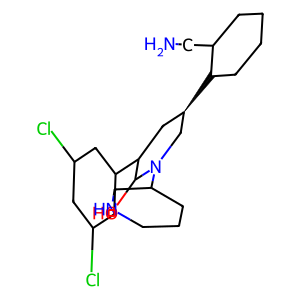

In [15]:
m=Chem.MolFromPDBFile('7L10-XEY.pdb')
Draw.MolToImage(m)

In [18]:
!obabel -ipdb 7L10-XEY.pdb -omol2 -O 7L10-XEY.mol2 -h

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is 7L10-XEY.pdb)

1 molecule converted


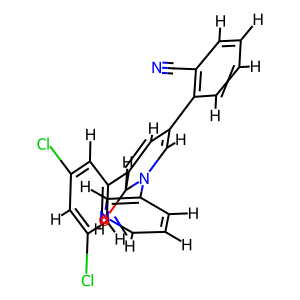

In [19]:
m=Chem.MolFromMol2File('7L10-XEY.mol2',sanitize=False)
Draw.MolToImage(m)


In [24]:
from openbabel import pybel

In [25]:
mol= [m for m in pybel.readfile(filename='7L10-XEY.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='7L10-XEY2.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

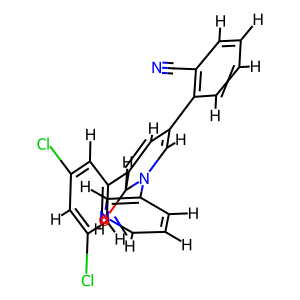

In [26]:
m=Chem.MolFromMol2File('7L10-XEY2.mol2',sanitize=False)
Draw.MolToImage(m)

In [30]:
!obabel -imol2 7L10-XEY2.mol2 -opdb -O 7L10-XEY2.pdb -h

1 molecule converted


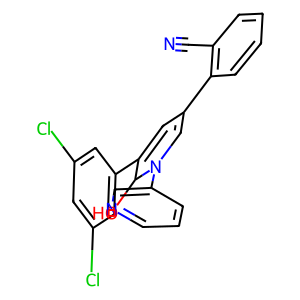

In [31]:
m=Chem.MolFromPDBFile('7L10-XEY2.pdb')
Draw.MolToImage(m)

In [ ]:
# Save the ligand and prepared protein together

In [32]:
#@title Write out a script for pymol
com_file = open('merge.pml','w')
com_file.write('''
load output.pdb
load 7L10-XEY2.pdb
h_add elem O or elem N
save complex_prepared.pdb, all   
''')
com_file.close()

In [ ]:
!pymol -c merge.pml

In [ ]:
# If you want to see proten-ligand interactions
# It become even more complex

In [ ]:
# Now you can just download your prepared complex

# It become even more complicated, If you want to see proten-ligand interactions,

In [ ]:
!conda install -c conda-forge mdanalysis

In [ ]:
!conda install -c conda-forge prolif

In [36]:
import MDAnalysis as mda
import prolif as plf

In [37]:

import numpy as np

# load topology
u = mda.Universe('complex_prepared.pdb')
lig = u.select_atoms("resname XEY")
prot = u.select_atoms("protein")

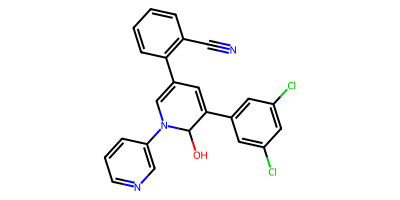

In [39]:
from rdkit import Chem
from rdkit.Chem import Draw

# create a molecule from the MDAnalysis selection
lmol = plf.Molecule.from_mda(lig)
# cleanup before drawing
mol = Chem.RemoveHs(lmol)
mol.RemoveAllConformers()
Draw.MolToImage(mol, size=(400, 200))

In [40]:
from prolif.plotting.network import LigNetwork

fp = plf.Fingerprint()
fp.run(u.trajectory[::10], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(
    df,
    lmol,
    # replace with `kind="frame", frame=0` for the other depiction
    kind="aggregate",
    threshold=0.3,
    rotation=270,
)
net.display()

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.8/multiprocessing/reduction.py:51: UserWarning: Reader has no dt information, set to 1.0 ps
  cls(buf, protocol).dump(obj)
/usr/local/lib/python3.8/site-packages/prolif/plotting/network.py:292: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.get_dummies(
/usr/local/lib/python3.8/site-packages/prolif/plotting/network.py:292: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.get_dummies(
/usr/local/lib/python3.8/site-packages/prolif/plotting/network.py:292: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.get_dummies(
